In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from copy import deepcopy

In [2]:
# scikit-learn에서 데이터셋 받아오고 확인하기

california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target
print(df.tail())

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  Target  
20635    -121.09   0.781  
20636    -121.21   0.771  
20637    -121.22   0.923  
20638    -121.32   0.847  
20639    -121.24   0.894  


In [3]:
# 데이터 준비
data = torch.from_numpy(df.values).float()

x = data[:, :-1]    # 마지막 행을 제외한 행들을 x로 설정
y = data[:, -1:]    # 마지막 행만 y로 설정

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [4]:
# 학습, 검증, 테스트 데이터 분할 비율 정의
ratios = [0.6, 0.2, 0.2]

train_cnt = int(data.size(0) * ratios[0])
val_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - val_cnt
cnts = [train_cnt, val_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, val_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples.


In [5]:
# 데이터 분할

# 데이터 섞기
indices = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

# 데이터를 학습/검증/테스트로 분할
x = list(x.split(cnts, dim=0))
y = y.split(cnts, dim=0)

# 각 분할된 데이터 크기 확인
for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


In [6]:
# 학습 데이터 기준으로 정규화

scaler = StandardScaler()
scaler.fit(x[0].numpy())

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

In [7]:
# 모델 정의

model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1))
)

print(model)
optimizer = optim.Adam(model.parameters()) # 옵티마이저 함수로 Adam 사용, 학습률 필요 X

# 학습 설정
epochs = 4000           # 학습 반복 횟수
batch_size = 256        # 배치 사이즈
interval = 100          # 학습 결과를 출력할 간격
lowest_loss = np.inf    # 최소 검증 손실
best_model = None       # 최소 검증 손실을 기록한 모델
early_stop = 100        # 성능이 나아지지 않을 때, 몇 번까지 더 기다릴지 정하는 값
lowest_epoch = np.inf   # 최소 검증 손실을 기록할 epoch 번호

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [8]:
# 모델 학습

train_history, val_history = [], [] # 학습/검증 손실 저장 리스트

for i in range(epochs):
    # 데이터 섞기 (무작위 인덱스 생성)
    indices = torch.randperm(x[0].size(0))

    # 입력 데이터와 정답 레이블을 같은 순서로 섞음
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    # 미니 배치로 분할
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, val_loss = 0, 0         # 학습, 검증 손실 값
    y_hat = []                          # 예측값을 저장할 리스트

    # 각 미니 배치에 대해 학습
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)            # 모델 예측값 계산
        loss = F.mse_loss(y_hat_i, y_i) # MSE 손실 계산

        optimizer.zero_grad()           # 기울기 초기화
        loss.backward()                 # 역전파로 기울기 계산
        optimizer.step()                # 가중치 업데이트

        train_loss += float(loss)       # 손실 누적
        
    train_loss /= len(x_)               # epoch별 평균 손실 계산

    # 검증 단계 (기울기 미계산)
    with torch.no_grad():
        # 검증 데이터를 미니 배치로 분할
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        val_loss = 0

        # 각 미니 배치에 대해 검증 수행
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)                # 예측 결과 계산
            loss = F.mse_loss(y_hat_i, y_i)     # MSE 손실 계산

            val_loss += loss                    # 배치 손실 값 누적
            y_hat += [y_hat_i]                  # 예측 결과를 리스트에 저장
    
    val_loss /= len(x_)                         # 평균 검증 손실 계산

    # 손실 기록
    train_history += [train_loss]
    val_history += [val_loss]

    # 일정 간격으로 손실 출력
    if (i + 1) % interval == 0:
        print('Epoch %d: train loss = %.4e    val loss = %.4e   lowest loss = %.4e' % (i + 1, train_loss, val_loss, lowest_loss))
    
    # 모델 저장 조건
    if val_loss <= lowest_loss:                     # 현재 검증 손실이 이전까지의 최소 손실보다 작거나 같다면:
        lowest_loss = val_loss                      # 최소 손실값 갱신
        lowest_epoch = i                            # 해당 에폭 번호 저장
        best_model = deepcopy(model.state_dict())   # 현재 모델 복사 저장
    else:
        # 조기 종료 조건 확인 (early_stop만큼의 에폭이 지나도록 개선이 없으면)
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break                                   # 학습 조기 종료

# 최적 모델 결과 출력 및 로드
print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 100: train loss = 3.9403e-01    val loss = 3.9607e-01   lowest loss = 3.9658e-01
Epoch 200: train loss = 3.6627e-01    val loss = 3.6436e-01   lowest loss = 3.6417e-01
Epoch 300: train loss = 3.4600e-01    val loss = 3.5622e-01   lowest loss = 3.5611e-01
Epoch 400: train loss = 3.3809e-01    val loss = 3.5293e-01   lowest loss = 3.5153e-01
Epoch 500: train loss = 3.3676e-01    val loss = 3.5134e-01   lowest loss = 3.5002e-01
Epoch 600: train loss = 3.3174e-01    val loss = 3.4885e-01   lowest loss = 3.4849e-01
Epoch 700: train loss = 3.2732e-01    val loss = 3.4755e-01   lowest loss = 3.4744e-01
Epoch 800: train loss = 3.2606e-01    val loss = 3.4774e-01   lowest loss = 3.4532e-01
Epoch 900: train loss = 3.2540e-01    val loss = 3.4552e-01   lowest loss = 3.4517e-01
Epoch 1000: train loss = 3.2342e-01    val loss = 3.4478e-01   lowest loss = 3.4247e-01
Epoch 1100: train loss = 3.2104e-01    val loss = 3.4290e-01   lowest loss = 3.4011e-01
Epoch 1200: train loss = 3.1828e-01    va

<All keys matched successfully>

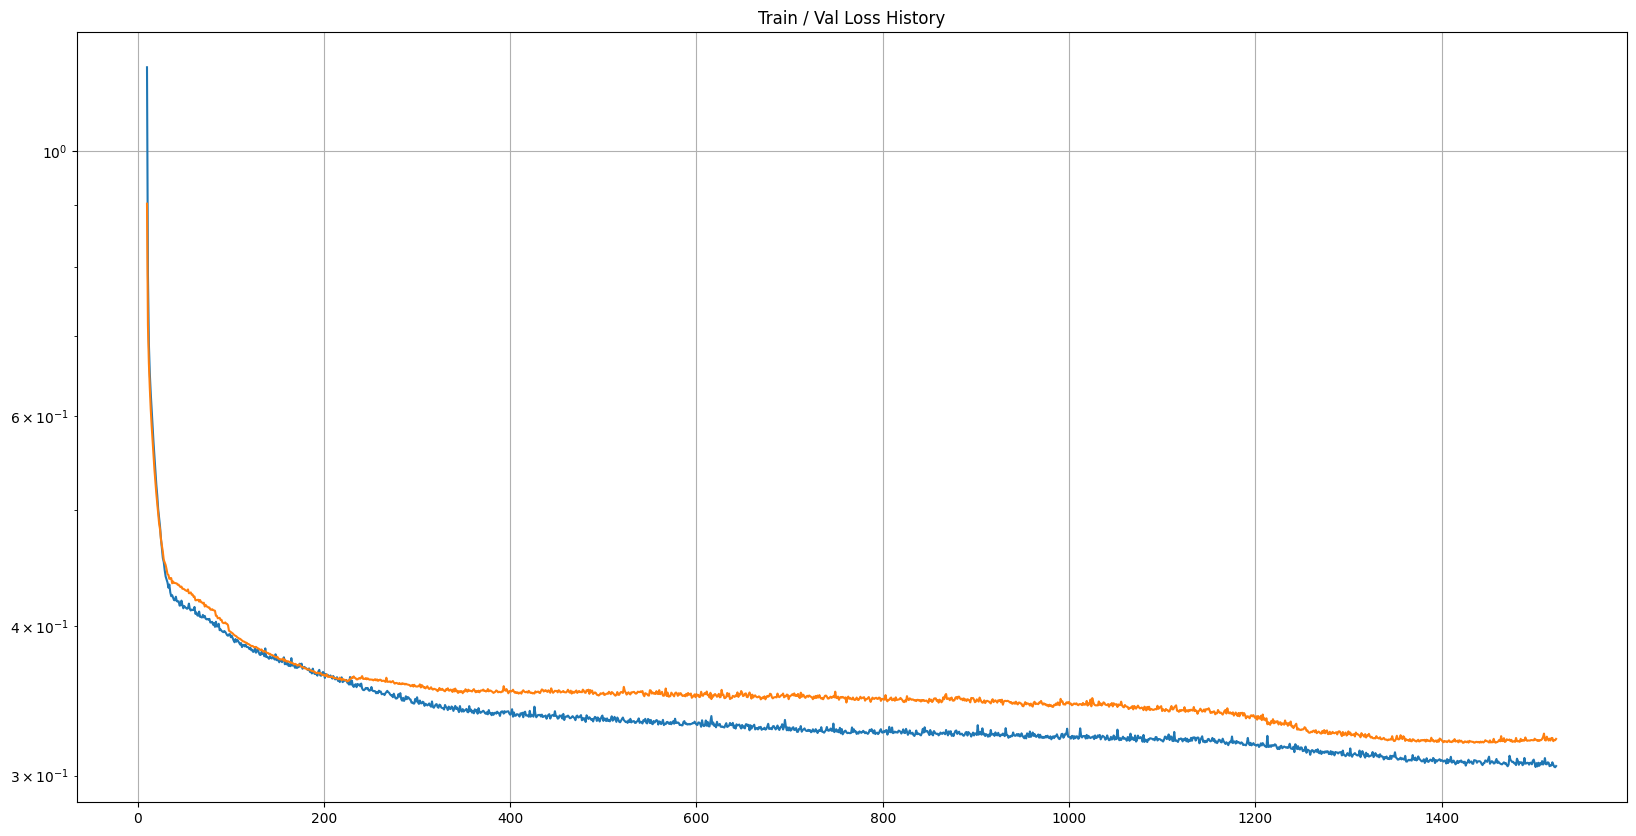

In [9]:
# 결과 시각화

plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Val Loss History")

plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(val_history)), val_history[plot_from:],
)

plt.yscale('log')
plt.show()

In [10]:
# 테스트 평가

test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += loss
        y_hat += [y_hat_i]

test_loss /= len(x_)                # 평균 테스트 손실
y_hat = torch.cat(y_hat, dim=0)     # 전체 예측 결과 병합

# 가장 낮은 검증 손실 기준으로 출력
sorted_history = sorted(zip(train_history, val_history), key=lambda x: x[1])
print("Train loss: %.4e" % sorted_history[0][0])
print("Val loss: %.4e" % sorted_history[0][1])
print("Test loss: %.4e" % test_loss)

Train loss: 3.0810e-01
Val loss: 3.1952e-01
Test loss: 3.0465e-01


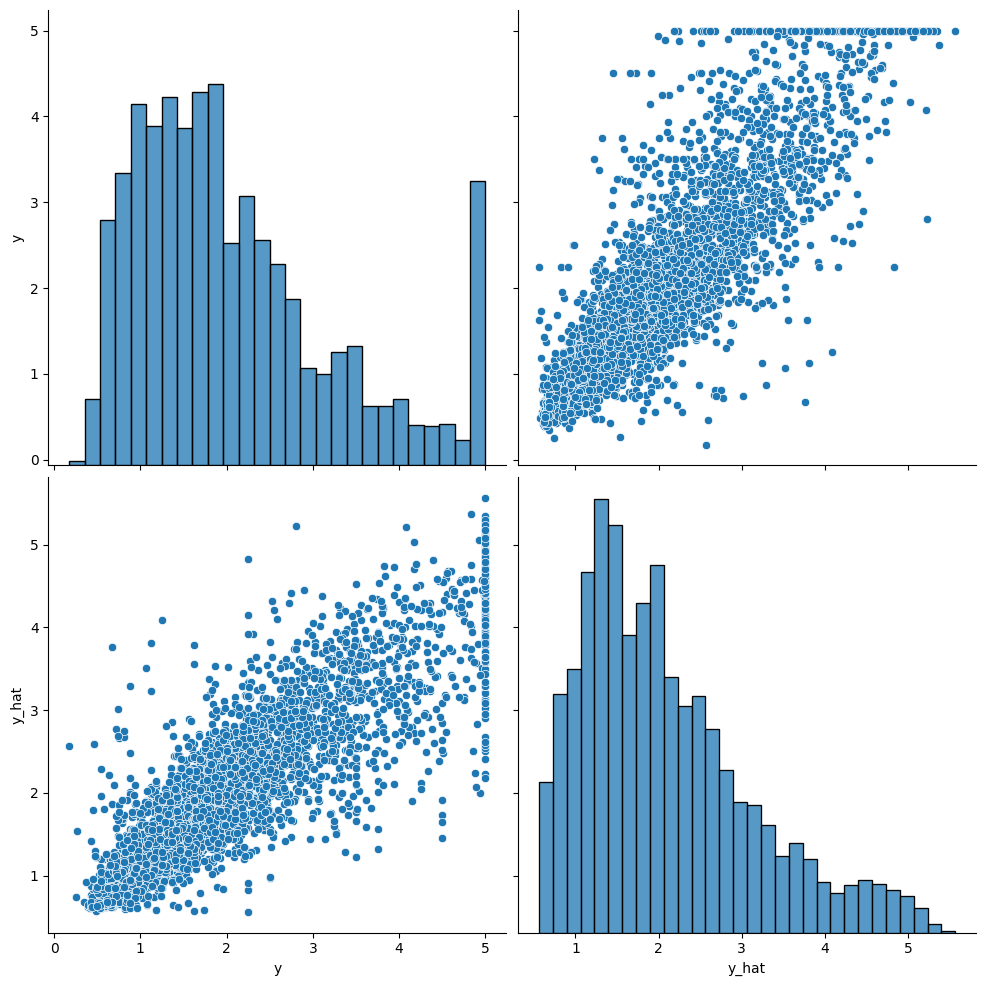

In [11]:
# 결과 시각화

df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(), columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()